# Keras Seq2Seq示例

+ 任务很简单，将数字转为中文大写金额，例如 11288 -> 壹万壹仟零捌拾捌元整
+ 我们将尝试利用seq2seq来解决这一问题，整个示例包括以下部分：
    + 建立数据集
    + 设计seq2seq模型
    + 对比不同seq2seq模型

## 建立数据集

+ 找到一个将数字转中文的python代码 http://blog.csdn.net/zzcwing/article/details/8763212 我们利用这个来建立数据集
+ 为了让事情变得简单一点，我们对数据集做一些约束：
    + 数据集中的数字大小不超过 10w，也就是说范围在[0, 99999]
    + 都是整数

In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

In [60]:
import random
import numpy as np

from keras import layers
from keras.layers import Input, Embedding, Bidirectional, Dense, Concatenate, LSTM
from keras.models import Model, load_model
from keras import callbacks

import matplotlib.pyplot as plt
%matplotlib inline

以下是数字转中文大写的代码，感谢作者

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 06 00:28:24 2013

@author: zzcwing
"""
#算法说明：要求字符串输入，现将字符串差费为整数部分和小数部分生成list[整数部分,小数部分]
#将整数部分拆分为：[亿，万，仟]三组字符串组成的List:['0000','0000','0000']（根据实际输入生成阶梯List）
#例如：600190000010.70整数部分拆分为：['600','1900','0010']
#然后对list中每个字符串分组进行大写化再合并
#最后处理小数部分的大写化

class cnumber:
    cdict={}
    gdict={}
    xdict={}
    def __init__(self):
        self.cdict={1:u'',2:u'拾',3:u'佰',4:u'仟'}
        self.xdict={1:u'元',2:u'万',3:u'亿',4:u'兆'} #数字标识符
        self.gdict={0:u'零',1:u'壹',2:u'贰',3:u'叁',4:u'肆',5:u'伍',6:u'陆',7:u'柒',8:u'捌',9:u'玖'}       

    def csplit(self,cdata): #拆分函数，将整数字符串拆分成[亿，万，仟]的list
        g=len(cdata)%4
        csdata=[]
        lx=len(cdata)-1
        if g>0:
            csdata.append(cdata[0:g])
        k=g
        while k<=lx:
            csdata.append(cdata[k:k+4])
            k+=4
        return csdata
    
    def cschange(self,cki): #对[亿，万，仟]的list中每个字符串分组进行大写化再合并
        
        lenki=len(cki)
        i=0
        lk=lenki
        chk=u''
        for i in range(lenki):
            if int(cki[i])==0:
                if i<lenki-1:
                    if int(cki[i+1])!=0:
                        chk=chk+self.gdict[int(cki[i])]                    
            else:
                chk=chk+self.gdict[int(cki[i])]+self.cdict[lk]
            lk-=1
        return chk
        
    def cwchange(self,data):
        if not '.' in data:
            data = data + '.00'
        cdata=str(data).split('.')
        
        cki=cdata[0]
        ckj=cdata[1]
        i=0
        chk=u''
        cski=self.csplit(cki) #分解字符数组[亿，万，仟]三组List:['0000','0000','0000']
        ikl=len(cski) #获取拆分后的List长度
        #大写合并
        for i in range(ikl):
            if self.cschange(cski[i])=='': #有可能一个字符串全是0的情况
                chk=chk+self.cschange(cski[i]) #此时不需要将数字标识符引入
            else:
                chk=chk+self.cschange(cski[i])+self.xdict[ikl-i] #合并：前字符串大写+当前字符串大写+标识符
        #处理小数部分
        lenkj=len(ckj)
        if lenkj==1: #若小数只有1位
            if int(ckj[0])==0: 
                chk=chk+u'整'
            else:
                chk=chk+self.gdict[int(ckj[0])]+u'角整'
        else: #若小数有两位的四种情况
            if int(ckj[0])==0 and int(ckj[1])!=0:
                chk=chk+u'零'+self.gdict[int(ckj[1])]+u'分'
            elif int(ckj[0])==0 and int(ckj[1])==0:
                chk=chk+u'整'
            elif int(ckj[0])!=0 and int(ckj[1])!=0:
                chk=chk+self.gdict[int(ckj[0])]+u'角'+self.gdict[int(ckj[1])]+u'分'
            else:
                chk=chk+self.gdict[int(ckj[0])]+u'角整'
        return chk

生成数据，范围在[1, 99999]

In [4]:
pt=cnumber()

# 生成数据，并写入文件中
num_range = range(1, 100000)
data_path = 'dataset.txt'
with open(data_path, 'w') as f:
    for num in num_range:
        num_str = str(num)
        ch_num = pt.cwchange(num_str)
        f.write(num_str + '\t' + ch_num + '\n')

## 向量化数据

In [5]:
num_samples = 50000

data_path = 'dataset.txt'
# 读入数据
with open(data_path, 'r') as f:
    lines = f.read().split('\n')
    
# 打乱顺序
random.shuffle(lines)
# 显示部分数据
for line in lines[:10]:
    print(line)

72608	柒万贰仟陆佰零捌元整
17338	壹万柒仟叁佰叁拾捌元整
99815	玖万玖仟捌佰壹拾伍元整
38187	叁万捌仟壹佰捌拾柒元整
79028	柒万玖仟零贰拾捌元整
95661	玖万伍仟陆佰陆拾壹元整
29591	贰万玖仟伍佰玖拾壹元整
11372	壹万壹仟叁佰柒拾贰元整
31327	叁万壹仟叁佰贰拾柒元整
84890	捌万肆仟捌佰玖拾元整


In [6]:
input_texts = [] #输入数据，也就是数字字符串
target_texts = [] #目标数据，也就是中文大写字符串
input_characters = set()
target_characters = set()
# 分割数据为 input_texts 和 target_texts
# 且统计一些信息
for line in lines[: min(num_samples, len(lines)-1)]:
    try:
        input_text, target_text = line.split('\t')
    except ValueError:
        print('Error line:', line)
        input_text = ''
        target_text = ''
        
    # 计算 input_texts 中的 tokens数量
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # 计算 target_texts 中的 tokens数量
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
        
    # 用 '始'作为开始字符
    # 用 '终'作为结束字符
    target_text = '始' + target_text + '终'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

max_encoder_seq_length = max([ len(txt) for txt in input_texts])
max_decoder_seq_length = max([ len(txt) for txt in target_texts])

print('Nunmber of samples:', len(input_texts))
print('Max sequence length of input:', max_encoder_seq_length)
print('Max sequence length of outputs:', max_decoder_seq_length)

Nunmber of samples: 50000
Max sequence length of input: 5
Max sequence length of outputs: 13


In [7]:
# 建立字典，用于字符转数字

# '[pad]'表示填充字符
input_token_index = dict( [(char, i) for i, char in enumerate(['pad']+input_characters)])

# '始'表示开始字符，'终'表示终止字符，'空'表示填充字符
special_characters = ['空', '始', '终']
target_token_index = dict([ (char,i ) for i, char in enumerate(special_characters + target_characters)])

num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)

In [8]:
def characters2index(text, char_index):
    # 将字符串向量化
    return [char_index.get(char) for char in text]

In [9]:
# 创建向量化的数据
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype=np.int32)
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length), dtype=np.int32)
# decoder_target_data 需要 one-hot 编码
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype=np.float32)

# 填充数据
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    input_indexs = characters2index(input_text, input_token_index)
    encoder_input_data[i, :len(input_indexs)] = input_indexs
    
    target_indexs = characters2index(target_text, target_token_index)
    decoder_input_data[i, :len(target_indexs)] = target_indexs
    
    # decoder_target_data 做one-hot编码，且偏移一位
    for t, index in enumerate(decoder_input_data[i, 1:]):
        decoder_target_data[i, t, index] = 1.0
    decoder_target_data[i, -1, 0] = 1.0


# 设计模型

In [10]:
# 超参数
encoder_embedding_dim = 10
decoder_embedding_dim = 20
latent_dim = 128

batch_size = 64
epochs = 20

### 单向模型
+ 编码器和解码器都是单向lstm
    + 编码器：encoder_input -> encoder_embedding -> encoder_lstm -> ...
    + 解码器：decoder_input -> decoder_embbeding -> decoder_lstm -> decoder_dense -> ...

In [11]:
def build_basic_model():
    rnn = layers.LSTM
    # Encoder
    encoder_inputs = Input(shape=(None,), name='encoder_inputs')
    encoder_embedding = Embedding(num_encoder_tokens, encoder_embedding_dim, name='encoder_embedding')(encoder_inputs)
    encoder_lstm = rnn(latent_dim, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.5, name='encoder_lstm')
    _, *encoder_states = encoder_lstm(encoder_embedding)
    
    # Decoder
    decoder_inputs = Input(shape=(None,), name='decoder_inputs')
    decoder_embedding = Embedding(num_decoder_tokens, decoder_embedding_dim, name='decoder_embedding')(decoder_inputs)
    decoder_lstm = rnn(latent_dim, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.5, name='decoder_lstm')
    rnn_outputs, *decoder_states = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(rnn_outputs)
    
    basic_model = Model([encoder_inputs, decoder_inputs], [decoder_outputs])
    basic_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return basic_model

### 训练单向模型

In [12]:
# 回调函数
callback_list = [callbacks.ModelCheckpoint('basic_model_best.h', save_best_only=True)]
# 获取模型
basic_model = build_basic_model()
# 训练
basic_model_hist = basic_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                batch_size=batch_size, epochs=epochs,
                validation_split=0.2, callbacks=callback_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 49s 1ms/step - loss: 1.2564 - val_loss: 0.7960


/home/nls3/anaconda2/envs/keras/lib/python3.6/site-packages/keras/engine/topology.py:2364: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/20
40000/40000 [==============================] - 43s 1ms/step - loss: 0.7724 - val_loss: 0.6788
Epoch 3/20
40000/40000 [==============================] - 47s 1ms/step - loss: 0.5891 - val_loss: 0.3697
Epoch 4/20
40000/40000 [==============================] - 46s 1ms/step - loss: 0.3621 - val_loss: 0.1546
Epoch 5/20
40000/40000 [==============================] - 43s 1ms/step - loss: 0.2083 - val_loss: 0.0564
Epoch 6/20
40000/40000 [==============================] - 41s 1ms/step - loss: 0.1248 - val_loss: 0.0201
Epoch 7/20
40000/40000 [==============================] - 40s 1ms/step - loss: 0.0772 - val_loss: 0.0079
Epoch 8/20
40000/40000 [==============================] - 42s 1ms/step - loss: 0.0491 - val_loss: 0.0033
Epoch 9/20
40000/40000 [==============================] - 47s 1ms/step - loss: 0.0334 - val_loss: 0.0018
Epoch 10/20
40000/40000 [==============================] - 45s 1ms/step - loss: 0.0240 - val_loss: 0.0011
Epoch 11/20
40000/40000 [=============================

### 测试单向模型

In [13]:
# 建立推理模型
def build_basic_inference_model(model_path):
    model = load_model(model_path)
    
    # encoder
    encoder_inputs = Input(shape=(None,))
    # encoder_embedding
    encoder_embedding = model.get_layer('encoder_embedding')(encoder_inputs)
    # get encoder states
    _, *encoder_states = model.get_layer('encoder_lstm')(encoder_embedding)
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # decoder
    # decoder inputs
    decoder_inputs = Input(shape=(None,))
    # decoder input states 
    decoder_state_h = Input(shape=(latent_dim,))
    decoder_state_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_h, decoder_state_c]
    
    # decoder embedding
    decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
    # get rnn outputs and decoder states
    rnn_outputs, *decoder_states = model.get_layer('decoder_lstm')(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_outputs = model.get_layer('decoder_dense')(rnn_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs]+decoder_states)
    
    return encoder_model, decoder_model

In [14]:
reverse_input_char_index = dict([(i, char) for char, i in input_token_index.items()])
reverse_target_word_index = dict([(i, char) for char, i in target_token_index.items()])

def decode_sequence(input_seq, encoder_model, decoder_model):
    # get encoder states
    states_value = encoder_model.predict(input_seq)

    # create a empty sequence
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['始']
    
    # 进行句子的恢复
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output, *decoder_states = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += sampled_word
        
        if sampled_word == '终' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
            
        # update target_seq
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # update states
        states_value = decoder_states
        
    return decoded_sentence

In [42]:
# 建立一些测试用的样本
test_input_texts = [line.split('\t')[0] for line in lines[-20:]]
test_input_data = np.zeros((len(test_input_texts), max_encoder_seq_length), np.int32)
for i, test_text in enumerate(test_input_texts):
    test_indexs = characters2index(test_text, input_token_index)
    test_input_data[i, :len(test_indexs)] = test_indexs

In [47]:
# 导入模型
model_path = 'basic_model_best.h'
inference_encoder_model, inference_decoder_model = build_basic_inference_model(model_path)

In [48]:
# 测试
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, inference_encoder_model, inference_decoder_model)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 59798
Decoded sentence: 伍万玖仟柒佰玖拾捌元整终
-
Input sentence: 28307
Decoded sentence: 贰万捌仟叁佰零柒元整终
-
Input sentence: 49323
Decoded sentence: 肆万玖仟叁佰贰拾叁元整终
-
Input sentence: 24169
Decoded sentence: 贰万肆仟壹佰陆拾玖元整终
-
Input sentence: 95323
Decoded sentence: 玖万伍仟叁佰贰拾叁元整终
-
Input sentence: 50104
Decoded sentence: 伍万零壹佰零肆元整终
-
Input sentence: 34650
Decoded sentence: 叁万肆仟陆佰伍拾元整终
-
Input sentence: 60256
Decoded sentence: 陆万零贰佰伍拾陆元整终
-
Input sentence: 42183
Decoded sentence: 肆万贰仟壹佰捌拾叁元整终
-
Input sentence: 68802
Decoded sentence: 陆万捌仟捌佰零贰元整终
-
Input sentence: 63819
Decoded sentence: 陆万叁仟捌佰壹拾玖元整终
-
Input sentence: 32531
Decoded sentence: 叁万贰仟伍佰叁拾壹元整终
-
Input sentence: 25678
Decoded sentence: 贰万伍仟陆佰柒拾捌元整终
-
Input sentence: 42272
Decoded sentence: 肆万贰仟贰佰柒拾贰元整终
-
Input sentence: 48908
Decoded sentence: 肆万捌仟玖佰零捌元整终
-
Input sentence: 74546
Decoded sentence: 柒万肆仟伍佰肆拾陆元整终
-
Input sentence: 11869
Decoded sentence: 壹万壹仟捌佰陆拾玖元整终
-
Input sentence: 75803
Decoded sentence: 柒万伍仟捌佰零叁元整终
-
Input sentence: 

### 双向编码器模型
+ 编码器使用双向的lstm，解码器使用单向的lstm
    + 编码器：encoder_input -> encoder_embedding -> bidi_encoder_lstm -> ...
    + 解码器：decoder_input -> decoder_embbeding -> decoder_lstm -> decoder_dense -> ...
    
+ 由于编码器是双向的，其状态包括 `forward_h, forward_c, backward_h, backward_c`，每个状态的`shape=(?, latent_dim)`，需要将foward 和 backward的状态进行合并，合并成为 `state_h, state_c`，其`shape=(?, latent_dim*2)`
+ 因此，解码器为了能够接收编码器的状态，解码器的latent_dim要与`state_h, state_c`一致，因此解码器的LSTM单元数量是两倍的

In [49]:
def build_bidi_encoder_model():
    rnn = layers.LSTM
    
    # Encoder
    # encoder inputs
    encoder_inputs = Input(shape=(None,), name='encoder_inputs')
    # encoder embedding
    encoder_embedding = Embedding(num_encoder_tokens, encoder_embedding_dim,name='encoder_embedding')(encoder_inputs)
    # encoder lstm
    bidi_encoder_lstm = Bidirectional(rnn(latent_dim, return_state=True, dropout=0.2,recurrent_dropout=0.5), name='encoder_lstm')
    _, forward_h, forward_c, backward_h, backward_c = bidi_encoder_lstm(encoder_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    # Decoder
    # decoder inputs
    decoder_inputs = Input(shape=(None,), name='decoder_inputs')
    # decoder embeddding
    decoder_embedding = Embedding(num_decoder_tokens, decoder_embedding_dim, name='decoder_embedding')(decoder_inputs)
    # decoder lstm, number of units is 2*latent_dim
    # NOTE THIS : latent_dim*2 for matching encoder_states
    decoder_lstm = rnn(latent_dim*2, return_state=True, 
                       return_sequences=True, dropout=0.2,
                       recurrent_dropout=0.5, name='decoder_lstm')
    # get outputs and decoder states
    rnn_outputs, *decoder_states = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    # decoder dense
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(rnn_outputs)
    
    bidi_encoder_model = Model([encoder_inputs,decoder_inputs], [decoder_outputs])
    bidi_encoder_model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return bidi_encoder_model

### 训练双向编码器模型

In [50]:
# 回调函数
callback_list = [callbacks.ModelCheckpoint('bidi_encoder_model_best.h', save_best_only=True)]
# 获取模型
bidi_encoder_model = build_bidi_encoder_model()
# 训练
bidi_encoder_model_hist = bidi_encoder_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                batch_size=batch_size, epochs=epochs,
                validation_split=0.2, callbacks=callback_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 66s 2ms/step - loss: 1.1616 - val_loss: 0.7842


/home/nls3/anaconda2/envs/keras/lib/python3.6/site-packages/keras/engine/topology.py:2364: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/20
40000/40000 [==============================] - 53s 1ms/step - loss: 0.7496 - val_loss: 0.5850
Epoch 3/20
40000/40000 [==============================] - 58s 1ms/step - loss: 0.4799 - val_loss: 0.2103
Epoch 4/20
40000/40000 [==============================] - 59s 1ms/step - loss: 0.1990 - val_loss: 0.0308
Epoch 5/20
40000/40000 [==============================] - 52s 1ms/step - loss: 0.0709 - val_loss: 0.0047
Epoch 6/20
40000/40000 [==============================] - 57s 1ms/step - loss: 0.0335 - val_loss: 0.0016
Epoch 7/20
40000/40000 [==============================] - 60s 2ms/step - loss: 0.0200 - val_loss: 7.4840e-04
Epoch 8/20
40000/40000 [==============================] - 54s 1ms/step - loss: 0.0131 - val_loss: 4.8027e-04
Epoch 9/20
40000/40000 [==============================] - 59s 1ms/step - loss: 0.0095 - val_loss: 3.4750e-04
Epoch 10/20
40000/40000 [==============================] - 59s 1ms/step - loss: 0.0074 - val_loss: 2.6341e-04
Epoch 11/20
40000/40000 [=============

In [51]:
def build_bidi_encoder_inference_model(model_path):
    model = load_model(model_path)
    
    # encoder
    encoder_inputs = Input(shape=(None,))
    # encoder_embedding
    encoder_embedding = model.get_layer('encoder_embedding')(encoder_inputs)
    # get encoder states
    _, forward_h, forward_c, backward_h, backward_c = model.get_layer('encoder_lstm')(encoder_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # decoder
    # decoder inputs
    decoder_inputs = Input(shape=(None,))
    # decoder input states 
    decoder_state_h = Input(shape=(latent_dim*2,))
    decoder_state_c = Input(shape=(latent_dim*2,))
    decoder_states_inputs = [decoder_state_h, decoder_state_c]
    
    # decoder embedding
    decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
    # get rnn outputs and decoder states
    rnn_outputs, *decoder_states = model.get_layer('decoder_lstm')(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_outputs = model.get_layer('decoder_dense')(rnn_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs]+decoder_states)
    
    return encoder_model, decoder_model

In [58]:
model_path = 'bidi_encoder_model_best.h'
inference_encoder_model, inference_decoder_model = build_bidi_encoder_inference_model(model_path)

In [59]:
# 测试
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, inference_encoder_model, inference_decoder_model)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 59798
Decoded sentence: 伍万玖仟柒佰玖拾捌元整终
-
Input sentence: 28307
Decoded sentence: 贰万捌仟叁佰零柒元整终
-
Input sentence: 49323
Decoded sentence: 肆万玖仟叁佰贰拾叁元整终
-
Input sentence: 24169
Decoded sentence: 贰万肆仟壹佰陆拾玖元整终
-
Input sentence: 95323
Decoded sentence: 玖万伍仟叁佰贰拾叁元整终
-
Input sentence: 50104
Decoded sentence: 伍万零壹佰零肆元整终
-
Input sentence: 34650
Decoded sentence: 叁万肆仟陆佰伍拾元整终
-
Input sentence: 60256
Decoded sentence: 陆万零贰佰伍拾陆元整终
-
Input sentence: 42183
Decoded sentence: 肆万贰仟壹佰捌拾叁元整终
-
Input sentence: 68802
Decoded sentence: 陆万捌仟捌佰零贰元整终
-
Input sentence: 63819
Decoded sentence: 陆万叁仟捌佰壹拾玖元整终
-
Input sentence: 32531
Decoded sentence: 叁万贰仟伍佰叁拾壹元整终
-
Input sentence: 25678
Decoded sentence: 贰万伍仟陆佰柒拾捌元整终
-
Input sentence: 42272
Decoded sentence: 肆万贰仟贰佰柒拾贰元整终
-
Input sentence: 48908
Decoded sentence: 肆万捌仟玖佰零捌元整终
-
Input sentence: 74546
Decoded sentence: 柒万肆仟伍佰肆拾陆元整终
-
Input sentence: 11869
Decoded sentence: 壹万壹仟捌佰陆拾玖元整终
-
Input sentence: 75803
Decoded sentence: 柒万伍仟捌佰零叁元整终
-
Input sentence: 

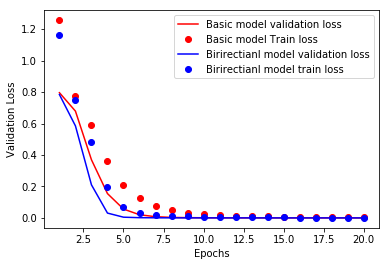

In [62]:
# 两种模型validation losss
basic_model_val_loss = basic_model_hist.history['val_loss']
bidi_model_val_loss = bidi_encoder_model_hist.history['val_loss']
basic_model_train_loss = basic_model_hist.history['loss']
bidi_model_train_loss = bidi_encoder_model_hist.history['loss']

x_range = range(1, len(basic_model_val_loss)+1)
plt.plot(x_range, basic_model_val_loss, 'r', label='Basic model validation loss')
plt.plot(x_range, basic_model_train_loss, 'ro', label='Basic model Train loss')


x_range = range(1, len(bidi_model_val_loss)+1)
plt.plot(x_range, bidi_model_val_loss, 'b', label='Birirectianl model validation loss')
plt.plot(x_range, bidi_model_train_loss, 'bo', label='Birirectianl model train loss')

plt.plot()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

## 总结
让我来总结下写代码时遇到的问题和坑
1. 在实现双向编码器模型时，刚开始不知道如何将encoder的states作为decoder的初始状态，查了好一会才找到如何实现，并且似乎只有在keras 2.1.3以上版本有用，具体在 https://stackoverflow.com/questions/47923370/keras-bidirectional-lstm-seq2seq ，关键就是要将decoder的latent_dim*2
2. 在预处理数据时，注意0的含义。在创建数据时，用的是np.zeros，如果0是代表着某个字符，那么训练将不正确，最好的办法是将0的含义设置为空
3. 我还尝试着将decoder设计成双向的RNN，结果表明，训练阶段没有任何问题，能够得到很小的loss，但是在inference阶段，完全没有作用，因此我在想：是否在seq2seq模型中decoder只能是单向的
4. 很明显，双向模型收敛速度快一些